# Pysersic Walkthrough: Fitting a single source

In this tutorial we'll walk through how to set up and fit a galaxy using `pysersic`. 

## Loading the data

We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
 - im: the image itself
 - mask: a mask indicating pixels which should not be included in the fit
 - sig: a map of pixel uncertainties 
 - psf: a map of the PSF (for now, only one psf can be used).

In [1]:
import numpy as np 
def load_data(n):
    im = np.load(f'examp_gals/gal{n}_im.npy')
    mask = np.load(f'examp_gals/gal{n}_mask.npy')
    sig = np.load(f'examp_gals/gal{n}_sig.npy')
    psf = np.load(f'examp_gals/gal{n}_psf.npy')
    return im,mask,sig,psf 

im,mask,sig,psf = load_data(1)

Let's visualize our galaxy, just to see what we're working with. You can do this any way you like. A convenience function is provided:

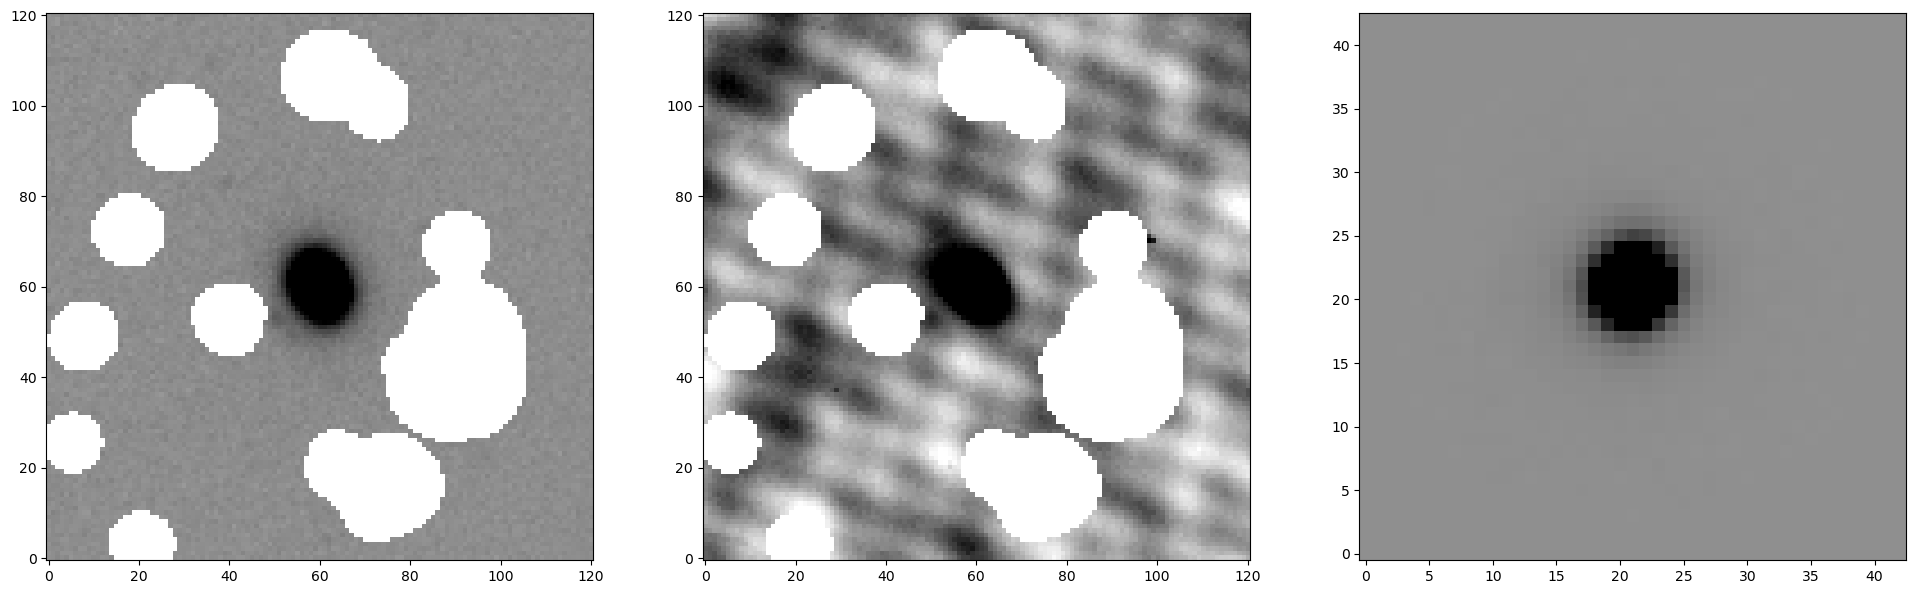

In [4]:
from pysersic.utils.visualization import plot_image

fig, ax = plot_image(im,mask,sig,psf)

## Fitting 

Now that we have our galaxy to fit, we can get set up with `pysersic`. 

Because we are fitting a single source, we'll want to initialize a `pysersic.FitSingle` object. For a field with multiple object, we would use `pysersic.FitMulti`. 

Additionally, we will need to set up a `pysersic.PysersicSourcePrior` object to handle the priors for the fit. (Again, using Source as we have a single galaxy to fit). 



In [2]:
from pysersic import PySersicSourcePrior

prior = PySersicSourcePrior(profile_type='sersic',sky_type='none')

The Source Prior takes two initial arguments, the profile type, whose options at current are
- sersic
- double sersic 
- point source
- exponential
- devaucoleurs 

and the sky_type, which indicates whether to fit the sky background, either with
- none (no fitting)
- flat (a single offset), or 
- tilted_plane 

At this point, we would need to write down priors for all of the fit parameters of a Sersic. However, there is an `autoprior` utility function that can more or less do this for us:


In [2]:
from pysersic.priors import autoprior 

prior = autoprior(im,profile_type='sersic',sky_type='flat',mask=mask)

The `autoprior()` function has a built-in choice about the prior functions to use for each sersic parameter, and then makes estimates for the parameters of those priors off of the image itself. We can print our prior to see what it chose:

In [6]:
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 1909.80, sigma = 43.70
r_eff ---  Truncated Normal w/ mu = 12.10, sigma = 3.48, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.50, sigma = 1.00
yc ---  Normal w/ mu = 60.50, sigma = 1.00

As we can see, this function used properties of the input image to make reasonable priors for the fit parameters. For now, let's continue, and in another example, we'll set some priors manually. 

Armed with our prior object, we can set up our `FitSingle` fitter. At this stage, we need to choose a `loss_func()`, which is used to evaluate the models to the data. For this example, we'll import the `student_t_loss()` from the `utils.loss` submodule. We recommend starting with student t, as it is less sensitive to outliers than a gaussian loss.

In [3]:
from pysersic import FitSingle
from pysersic.utils.loss import student_t_loss
fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

The set of currently implemented loss functions are:
- cash loss (Cash 1979)
- fractional gaussian loss 
- gaussian loss with a systematic offset
- student t loss
- student t loss with a free nu parameter
- student t loss with free nu and a systematic component. 

See the page on `Loss Functions` to learn more about these choices. For now, a gaussian loss will be fine.

With a fitter object created, we are now free to carry out a fit. 

Before we jump all the way into *sampling*, it's worth noting that we can also retrieve a prediction for the best fit model very quickly, using an SVI (stochastic variational inference). The simplest way to do this is to simply call the `best_fit()` method of our fitter, which will train an SVI and return a summary table of fit parameters:


In [4]:
res = fitter.best_fit()

 10%|▉         | 287/3000 [00:00<00:05, 476.65it/s, Round = 3,step_size = 1.6e-03 log(-loss): 9.7090]


In [6]:
res

results object for pysersic fit
	 contains SVI results True
	 contains sampling results: False

We can see that our result object now has SVI results (but no sampling results yet). As a note, these fit methods return the results object, but we can access it anytime by calling the `fitter.results` attribute:

In [6]:
fitter.results

results object for pysersic fit
	 contains SVI results True
	 contains sampling results: False

We can take a look at a summary table of the results as created by arviz -- this will be a dataframe:

In [6]:
res.svi_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ellip        0.263  0.003     0.258     0.268      0.000    0.000     965.0   
flux      1710.088  4.033  1702.080  1717.471      0.122    0.086    1089.0   
n            1.799  0.020     1.764     1.840      0.001    0.000     960.0   
r_eff        3.229  0.012     3.204     3.248      0.000    0.000     992.0   
sky_back     0.011  0.001     0.010     0.012      0.000    0.000    1093.0   
theta        2.049  0.006     2.038     2.059      0.000    0.000     802.0   
xc          60.045  0.005    60.035    60.053      0.000    0.000     975.0   
yc          60.054  0.006    60.042    60.064      0.000    0.000     938.0   

          ess_tail  r_hat  
ellip        955.0    NaN  
flux         835.0    NaN  
n           1020.0    NaN  
r_eff        789.0    NaN  
sky_back     941.0    NaN  
theta        788.0    NaN  
xc           981.0    NaN  
yc          1016.0    NaN

And we can create a model image using the best-fit (median) posterior parameters, specifying to render based on the SVI (rather than sampling) results:

In [5]:
mod = res.render_best_fit_model(which='SVI')

We can then use the `plot_residual` function to quickly compare model to the data:

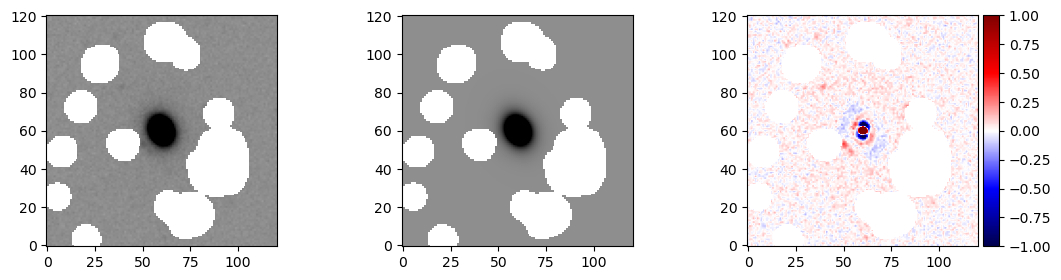

In [6]:
from pysersic.utils.visualization import plot_residual
fig, ax = plot_residual(im,mod,mask=mask,vmin=-1,vmax=1)

## Sampling 

Let's now try to sample. I'll use a student T loss:

We can run the `fitter.sample()` method with no arguments, which will default to 2000 samples in 2 chains. But `sample()` will take any `**kwargs` to be passed to the `mcmc.NUTS()` sampler under the hood.

In [7]:
fitter.sample()

/Users/ipasha/Dropbox/github/pysersic/pysersic/pysersic.py:133: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.sampler =infer.MCMC(infer.NUTS(model, **sampler_kwargs),**mcmc_kwargs)
sample: 100%|██████████| 2000/2000 [00:32<00:00, 62.17it/s, 7 steps of size 4.52e-01. acc. prob=0.90] 


results object for pysersic fit
	 contains SVI results True
	 contains sampling results: True

We can now check that our `res` object has results from both a sampling and an SVI run. We can also see that this fit (on a laptop cpu) took ~40s per chain of 2000 samples. `Pysersic` is optimized to work on a GPU via `jax` and `numpyro` --- this case, most of the runtime is actually in the compilation overhead. 

If we want to see the reuslts, we can retrieve an arviz summary table as follows:

In [6]:
res.sampling_summary()

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ellip        0.263  0.002     0.259     0.268      0.000    0.000    1740.0   
flux      1709.819  4.010  1701.606  1716.666      0.104    0.073    1492.0   
n            1.798  0.020     1.760     1.834      0.001    0.000    1537.0   
r_eff        3.228  0.012     3.206     3.252      0.000    0.000    1938.0   
sky_back     0.011  0.001     0.010     0.012      0.000    0.000    2392.0   
theta        2.050  0.006     2.039     2.060      0.000    0.000    2666.0   
xc          60.044  0.005    60.035    60.054      0.000    0.000    2776.0   
yc          60.054  0.006    60.044    60.064      0.000    0.000    2968.0   

          ess_tail  r_hat  
ellip       1277.0    1.0  
flux        1655.0    1.0  
n           1736.0    1.0  
r_eff       1611.0    1.0  
sky_back    1387.0    1.0  
theta       1372.0    1.0  
xc          1585.0    1.0  
yc          1624.0    1.0

As before, we can render out the median model, but now specifying we want to use the sampling results:

In [8]:
mod_sampling = res.render_best_fit_model(which='sampler')


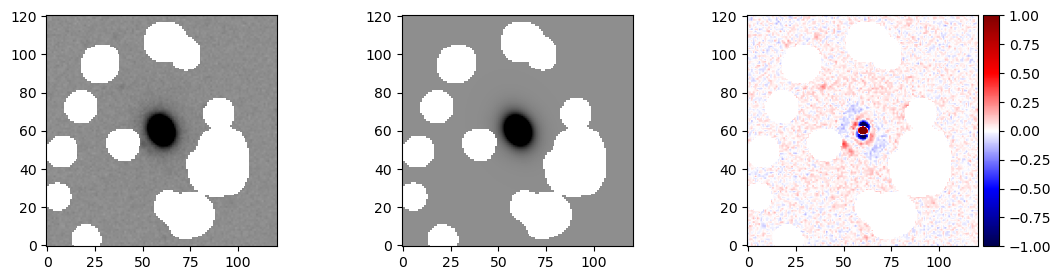

In [9]:
fig, ax = plot_residual(im,mod_sampling,mask=mask,vmin=-1,vmax=1)

## Other Diagnostics and Visualizations

Below we cover a few diagnostics we can look at. 

We can, for example, create corner plots for either the SVI results or sampling results:

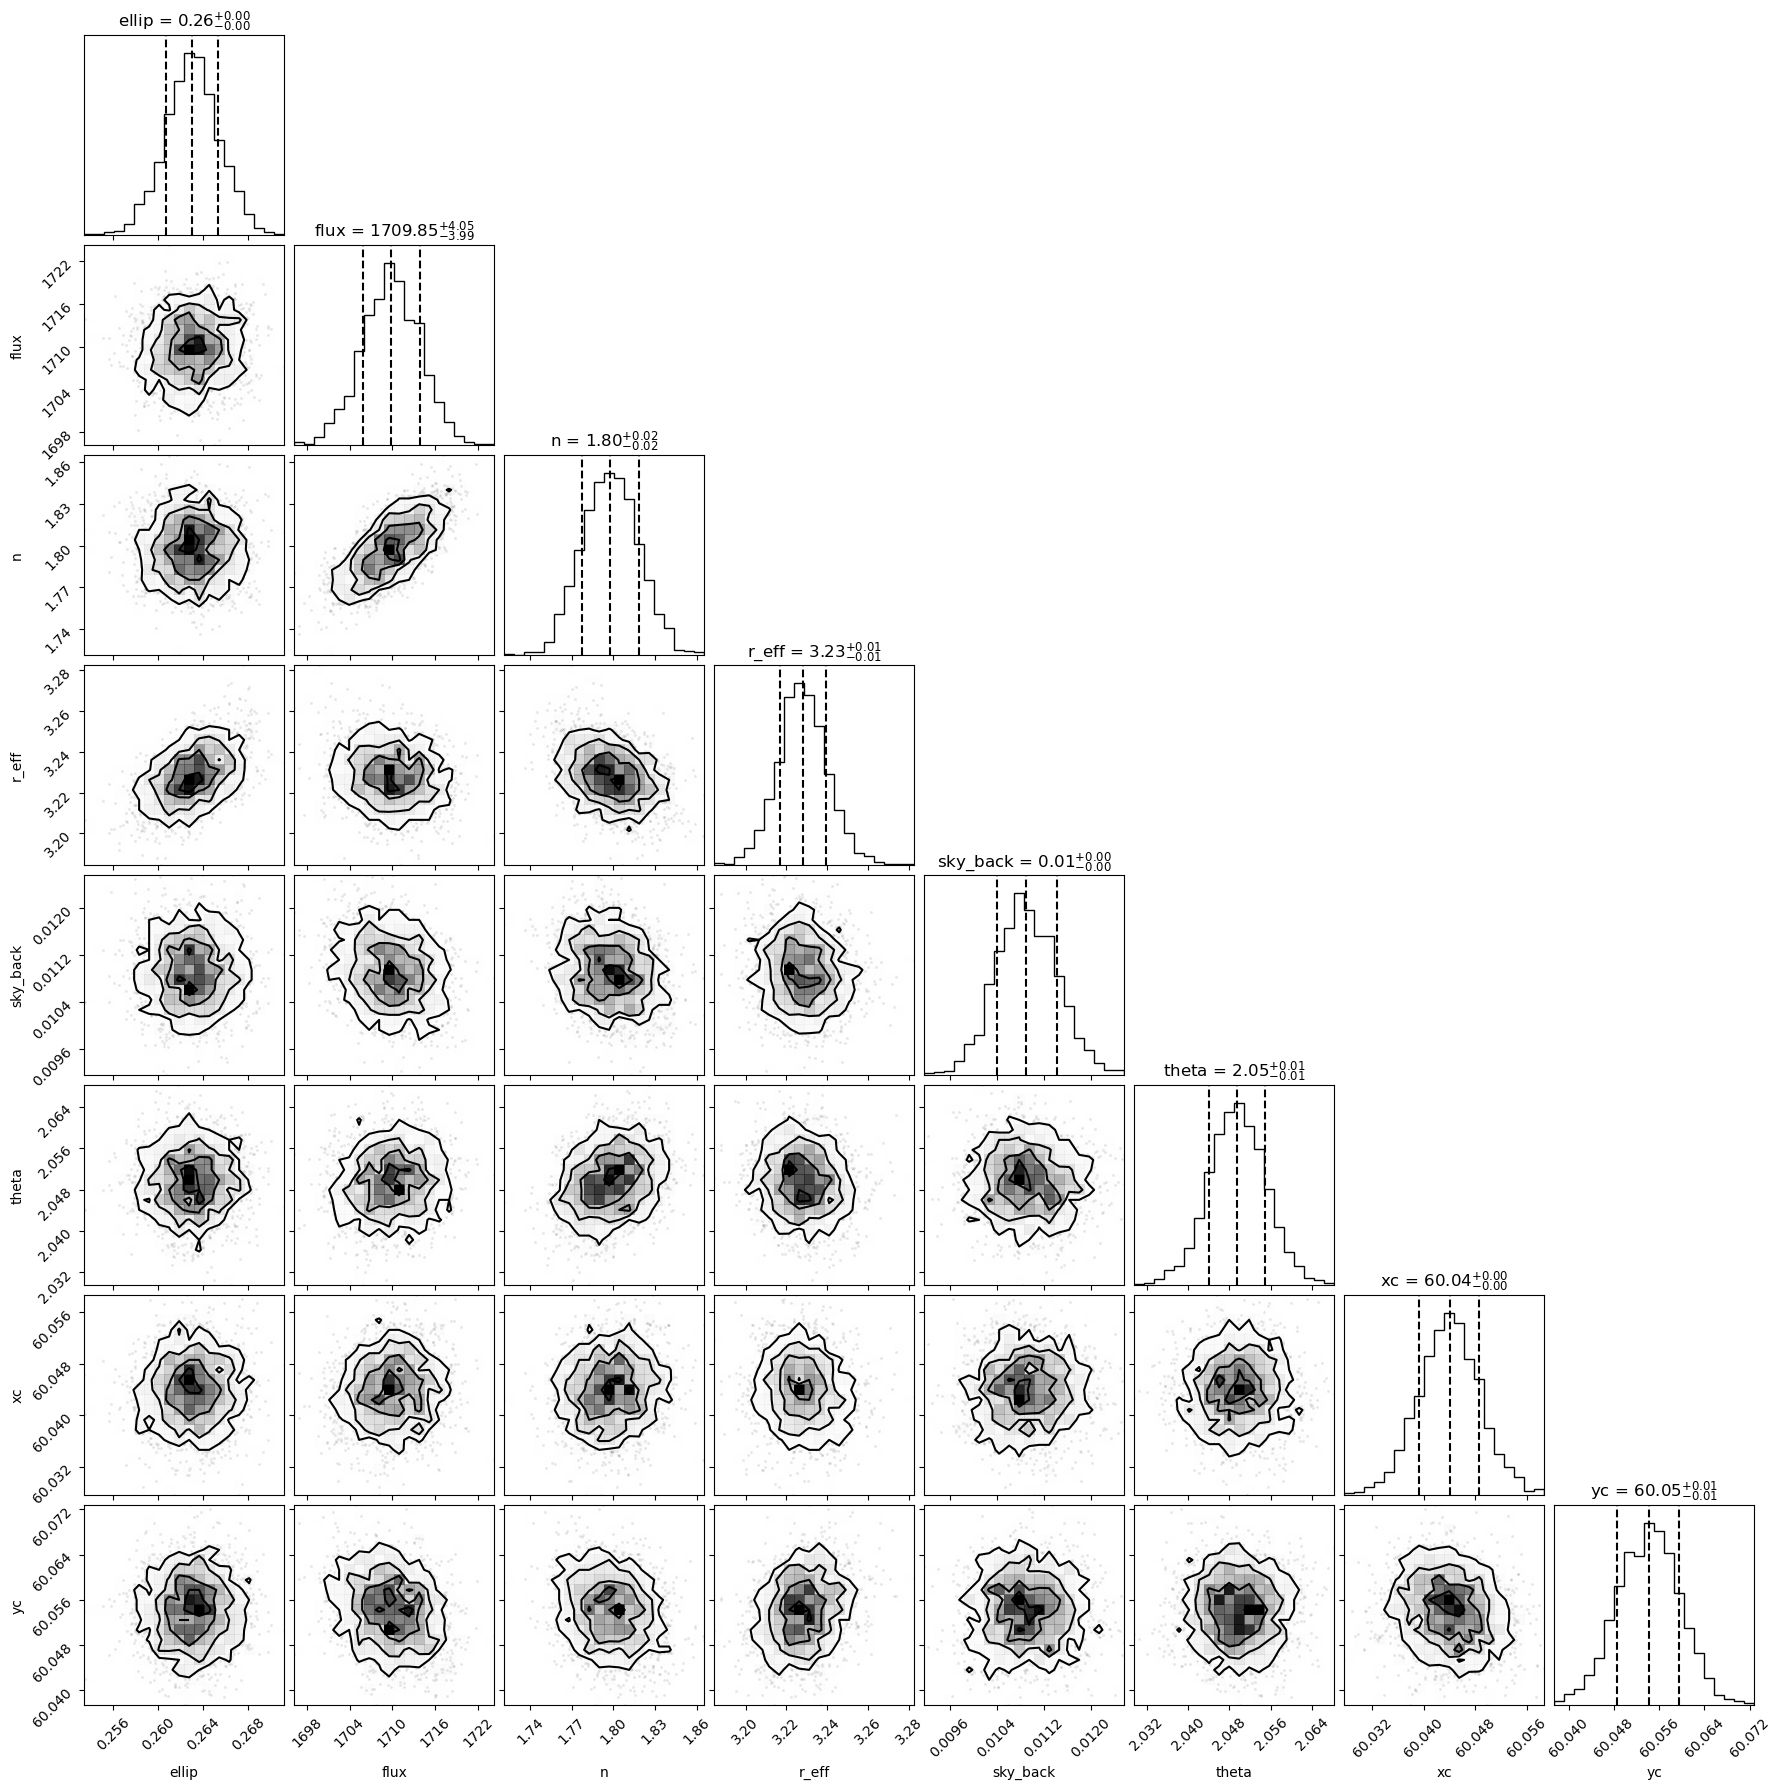

In [6]:
fig = fitter.results.corner(which='sampler')

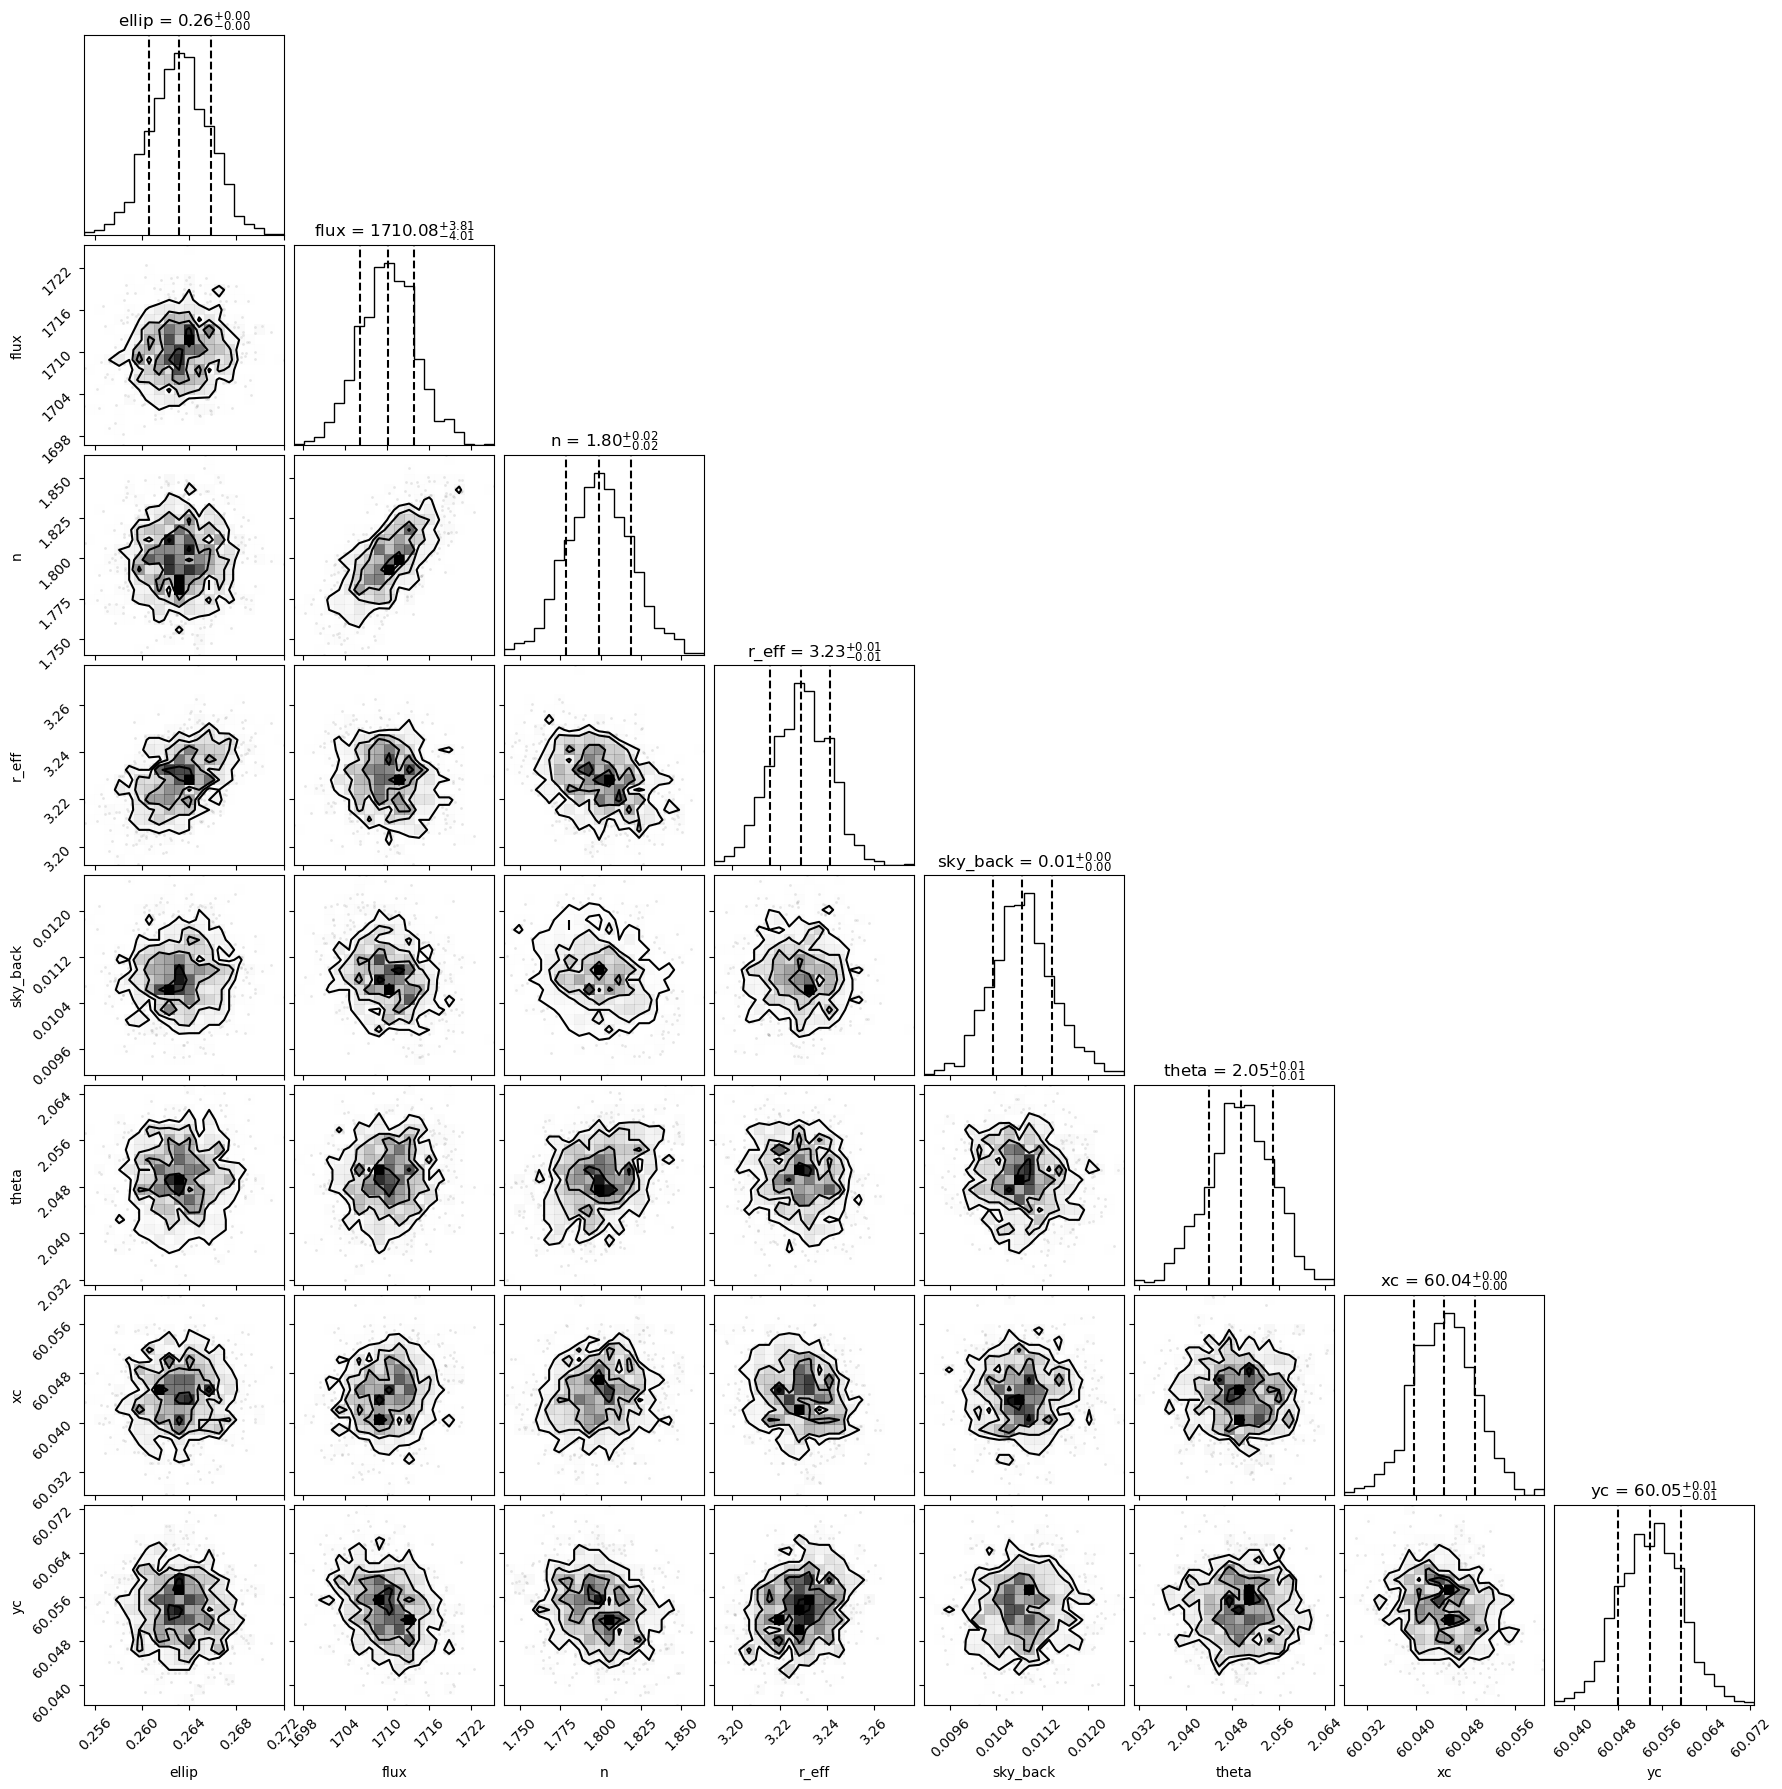

In [7]:
fig = fitter.results.corner(which='SVI')

And finally, because we have both, we can overplot and see how similar they are:

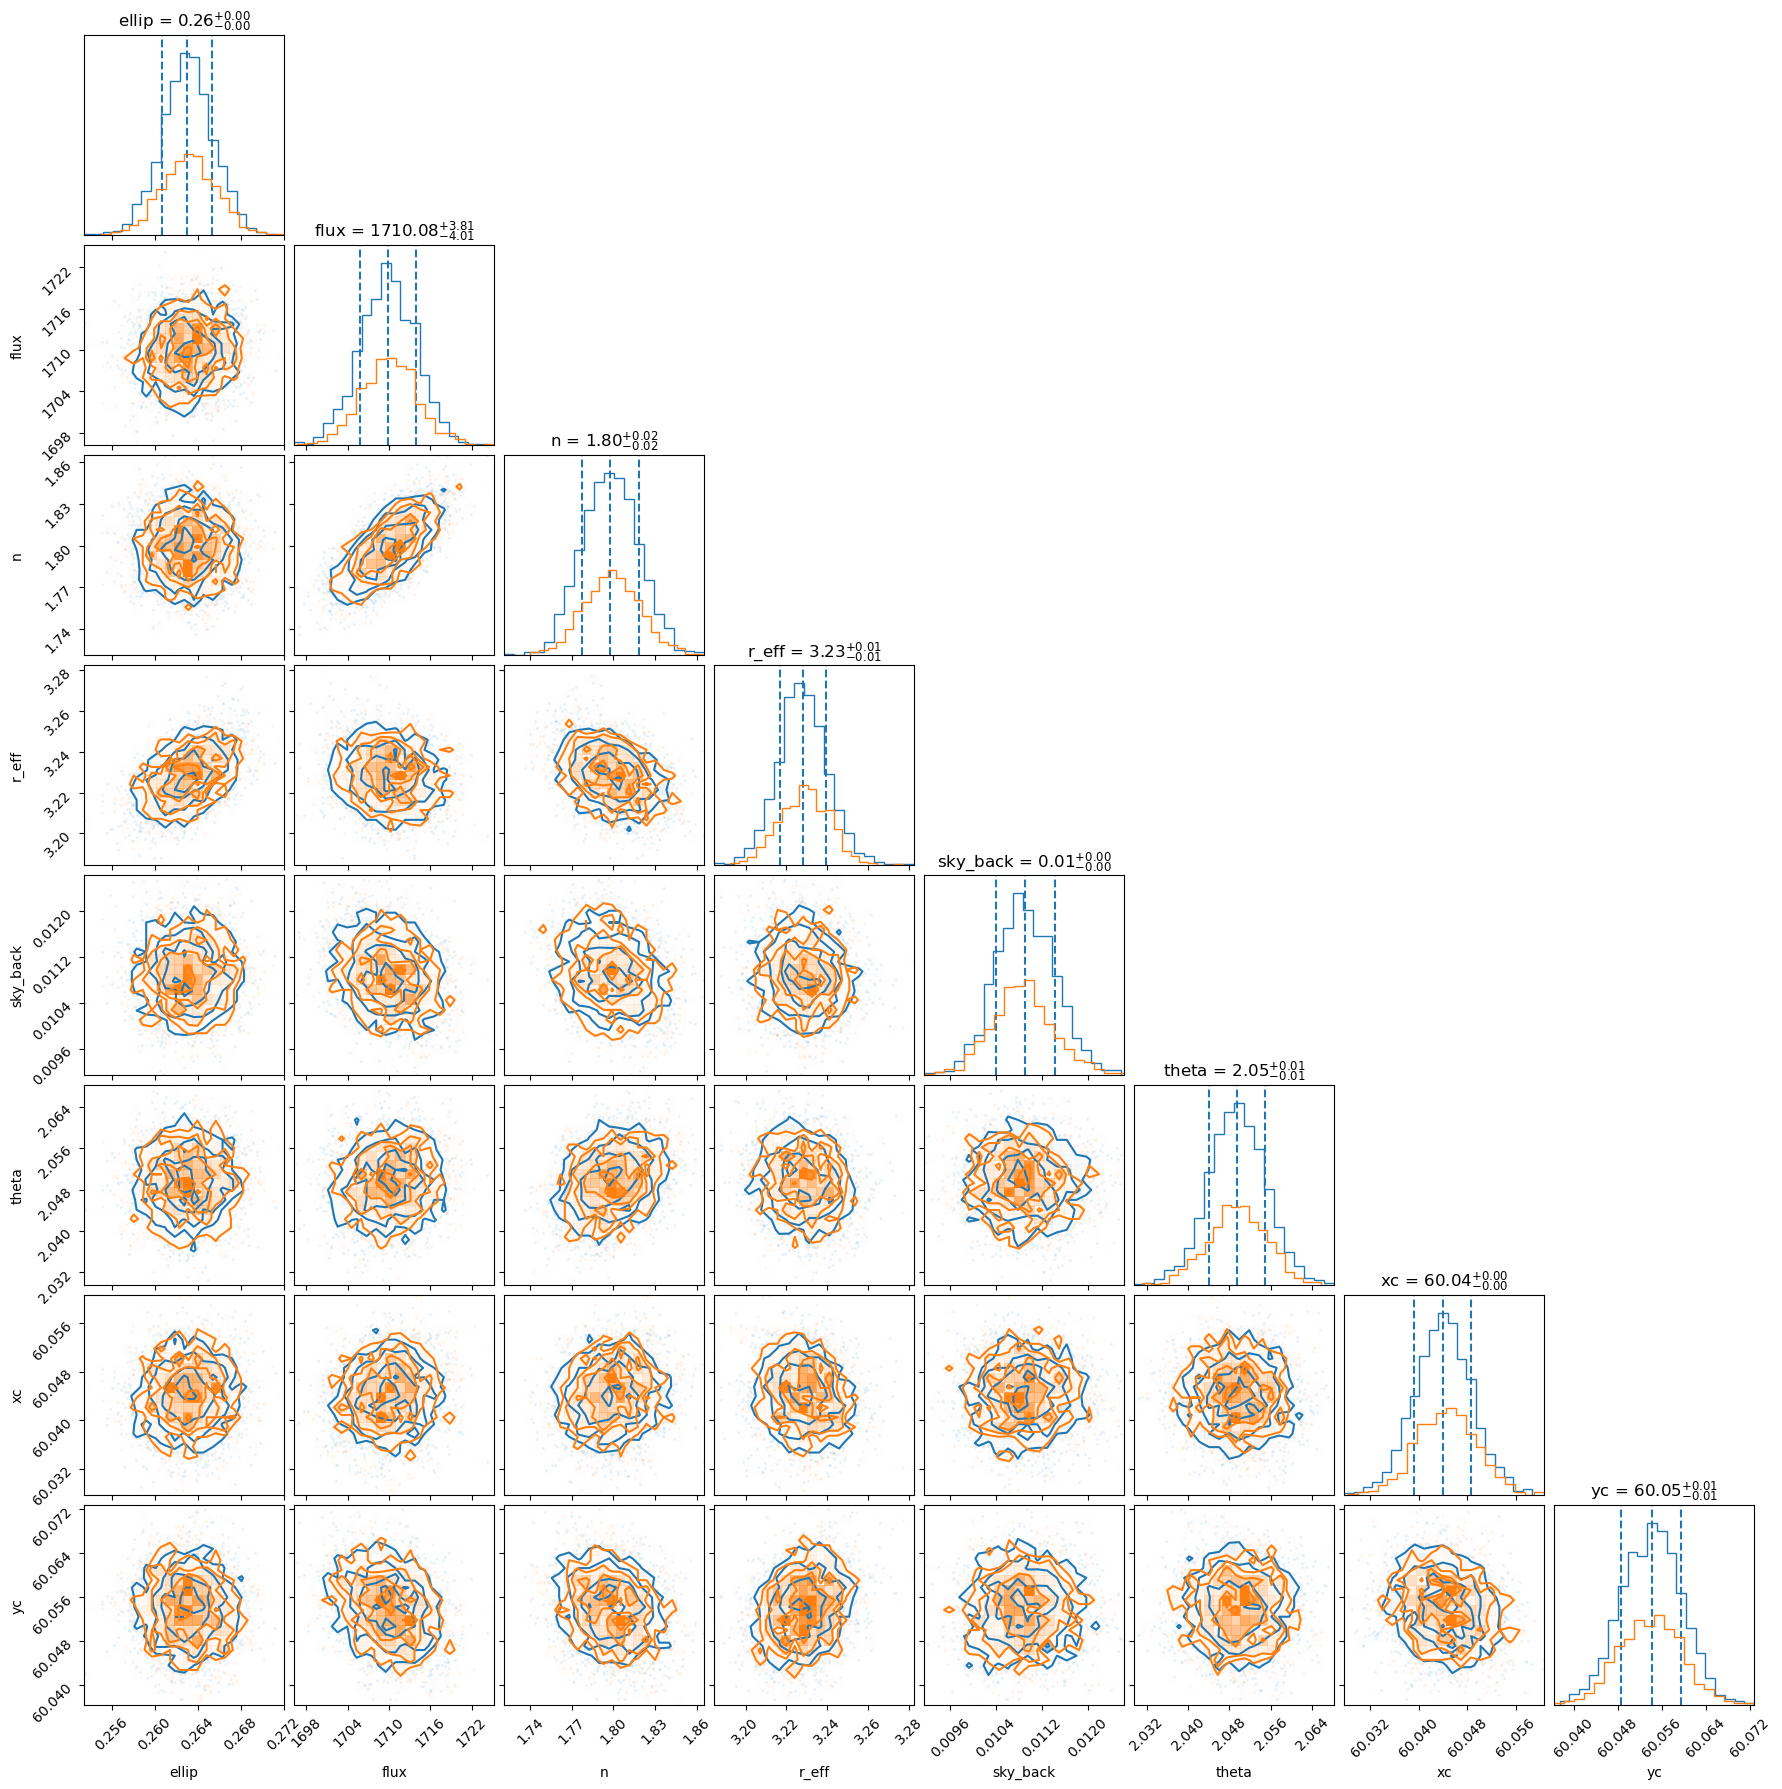

In [8]:
fig = fitter.results.corner(which='both')


If we want to retrieve a table with arbitrary quantiles for a fit, we can use the `retrieve_param_quantiles()` function. This will return either a dictionary (if `return_type='dict'`) or a data frame, with the requested quantiles as columns and the parameters as rows.

In [9]:
fitter.results.retrieve_param_quantiles(which='SVI',return_type='pandas')

0.16         0.50         0.84
ellip        0.260578     0.263144     0.265810
flux      1706.067173  1710.079041  1713.886748
n            1.778642     1.798995     1.818791
r_eff        3.215980     3.228931     3.241097
sky_back     0.010345     0.010849     0.011376
theta        2.043940     2.049577     2.054978
xc          60.039651    60.044575    60.049472
yc          60.048073    60.053913    60.059512

We can also print out a latex-ready table (using the AAStex deluxetable), if we would so like (the data portion of the table is easily copy-able to other formats).

In [5]:
fitter.results.latex_table()

\begin{deluxetable}{lr}[b]
\tablehead{
\colhead{Parameter} & \colhead{\hspace{4.5cm}Value\hspace{.5cm}}}
\caption{Best Fit Parameters for Pysersic Fit}
\startdata 
ellip & 0.263_{-0.003}^{+0.003} \\ 
flux & 1710.079_{-4.012}^{+3.808} \\ 
n & 1.799_{-0.020}^{+0.020} \\ 
r_{\rmeff} & 3.229_{-0.013}^{+0.012} \\ 
sky_{\rmback} & 0.011_{-0.001}^{+0.001} \\ 
\theta & 2.050_{-0.006}^{+0.005} \\ 
xc & 60.045_{-0.005}^{+0.005} \\ 
yc & 60.054_{-0.006}^{+0.006} \\ 
\enddata 
\end{deluxetable}


In [15]:
ellip_std = fitter.results.compute_statistic(which='SVI',parameter='ellip',func=np.std)
ellip_std

array(0.00252643, dtype=float32)

There are many more things we can do in terms of carrying out statistics on our outputs -- but since arviz has its own, well-vetted system for that, we trust that you can use the arviz inference data objects (`results.svi_results` and `results.sampling_results`) and run with them as needed.

## Saving the fit to a file 

Lastly, we may want to save the parameters of our fit (info, chains, models, data) to a file. This can be done with the `results.save_results()` method:

As we can see, the information needed to reconsitute the models and fit parameters are all stored in this file. The `'input_data'` dictionary in the tree contains a copy of the data that was fit. We can see which loss function and renderer was used. We can also access our prior printout:

In [10]:
fitter.results.save_result('example_fit.asdf')

We can (presumably at a later time) then load our asdf file and view what it contains:

In [11]:
import asdf 
af = asdf.open('example_fit.asdf')
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.14.3
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─best_sampling_model (NDArrayType): shape=(121, 121), dtype=float32
├─best_svi_model (NDArrayType): shape=(121, 121), dtype=float32
├─contains_SVI_result (str): True
├─contains_sampling_result (str): True
├─input_data (dict)
│ ├─image (NDArrayType): shape=(121, 121), dtype=float32
│ ├─mask (NDArrayType): shape=(121, 121), dtype=float64
│ ├─psf (NDArrayType): shape=(43, 43), dtype=float64
│ └─rms (NDArrayType): shape=(121, 121), dtype=float32
├─loss_func (str): <function student_t_loss at 0x7ff138c0a560>
├─prior_info (str): Prior for a sersic source:
--------------------------
flux ---  Normal w (truncated)
├─renderer (str): <pysersic.rendering.HybridRenderer object at 0x7ff15033de10>
├─sampling_posterior (dict) ...
└─svi_posterior (

As we can see, everything we need, from the input data, to which loss function, to the prior info, and finally the posterior chains, are stored in this file. For example, to see what our priors were:

In [12]:
print(af.tree['prior_info'])

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 1909.80, sigma = 43.70
r_eff ---  Truncated Normal w/ mu = 12.10, sigma = 3.48, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.50, sigma = 1.00
yc ---  Normal w/ mu = 60.50, sigma = 1.00



And finally, the posterior chains for the fits are in the `'svi_posterior'` and `'sampling_posterior'` dictionaries within the tree. As a result, we can quickly re-constitute a corner plot:

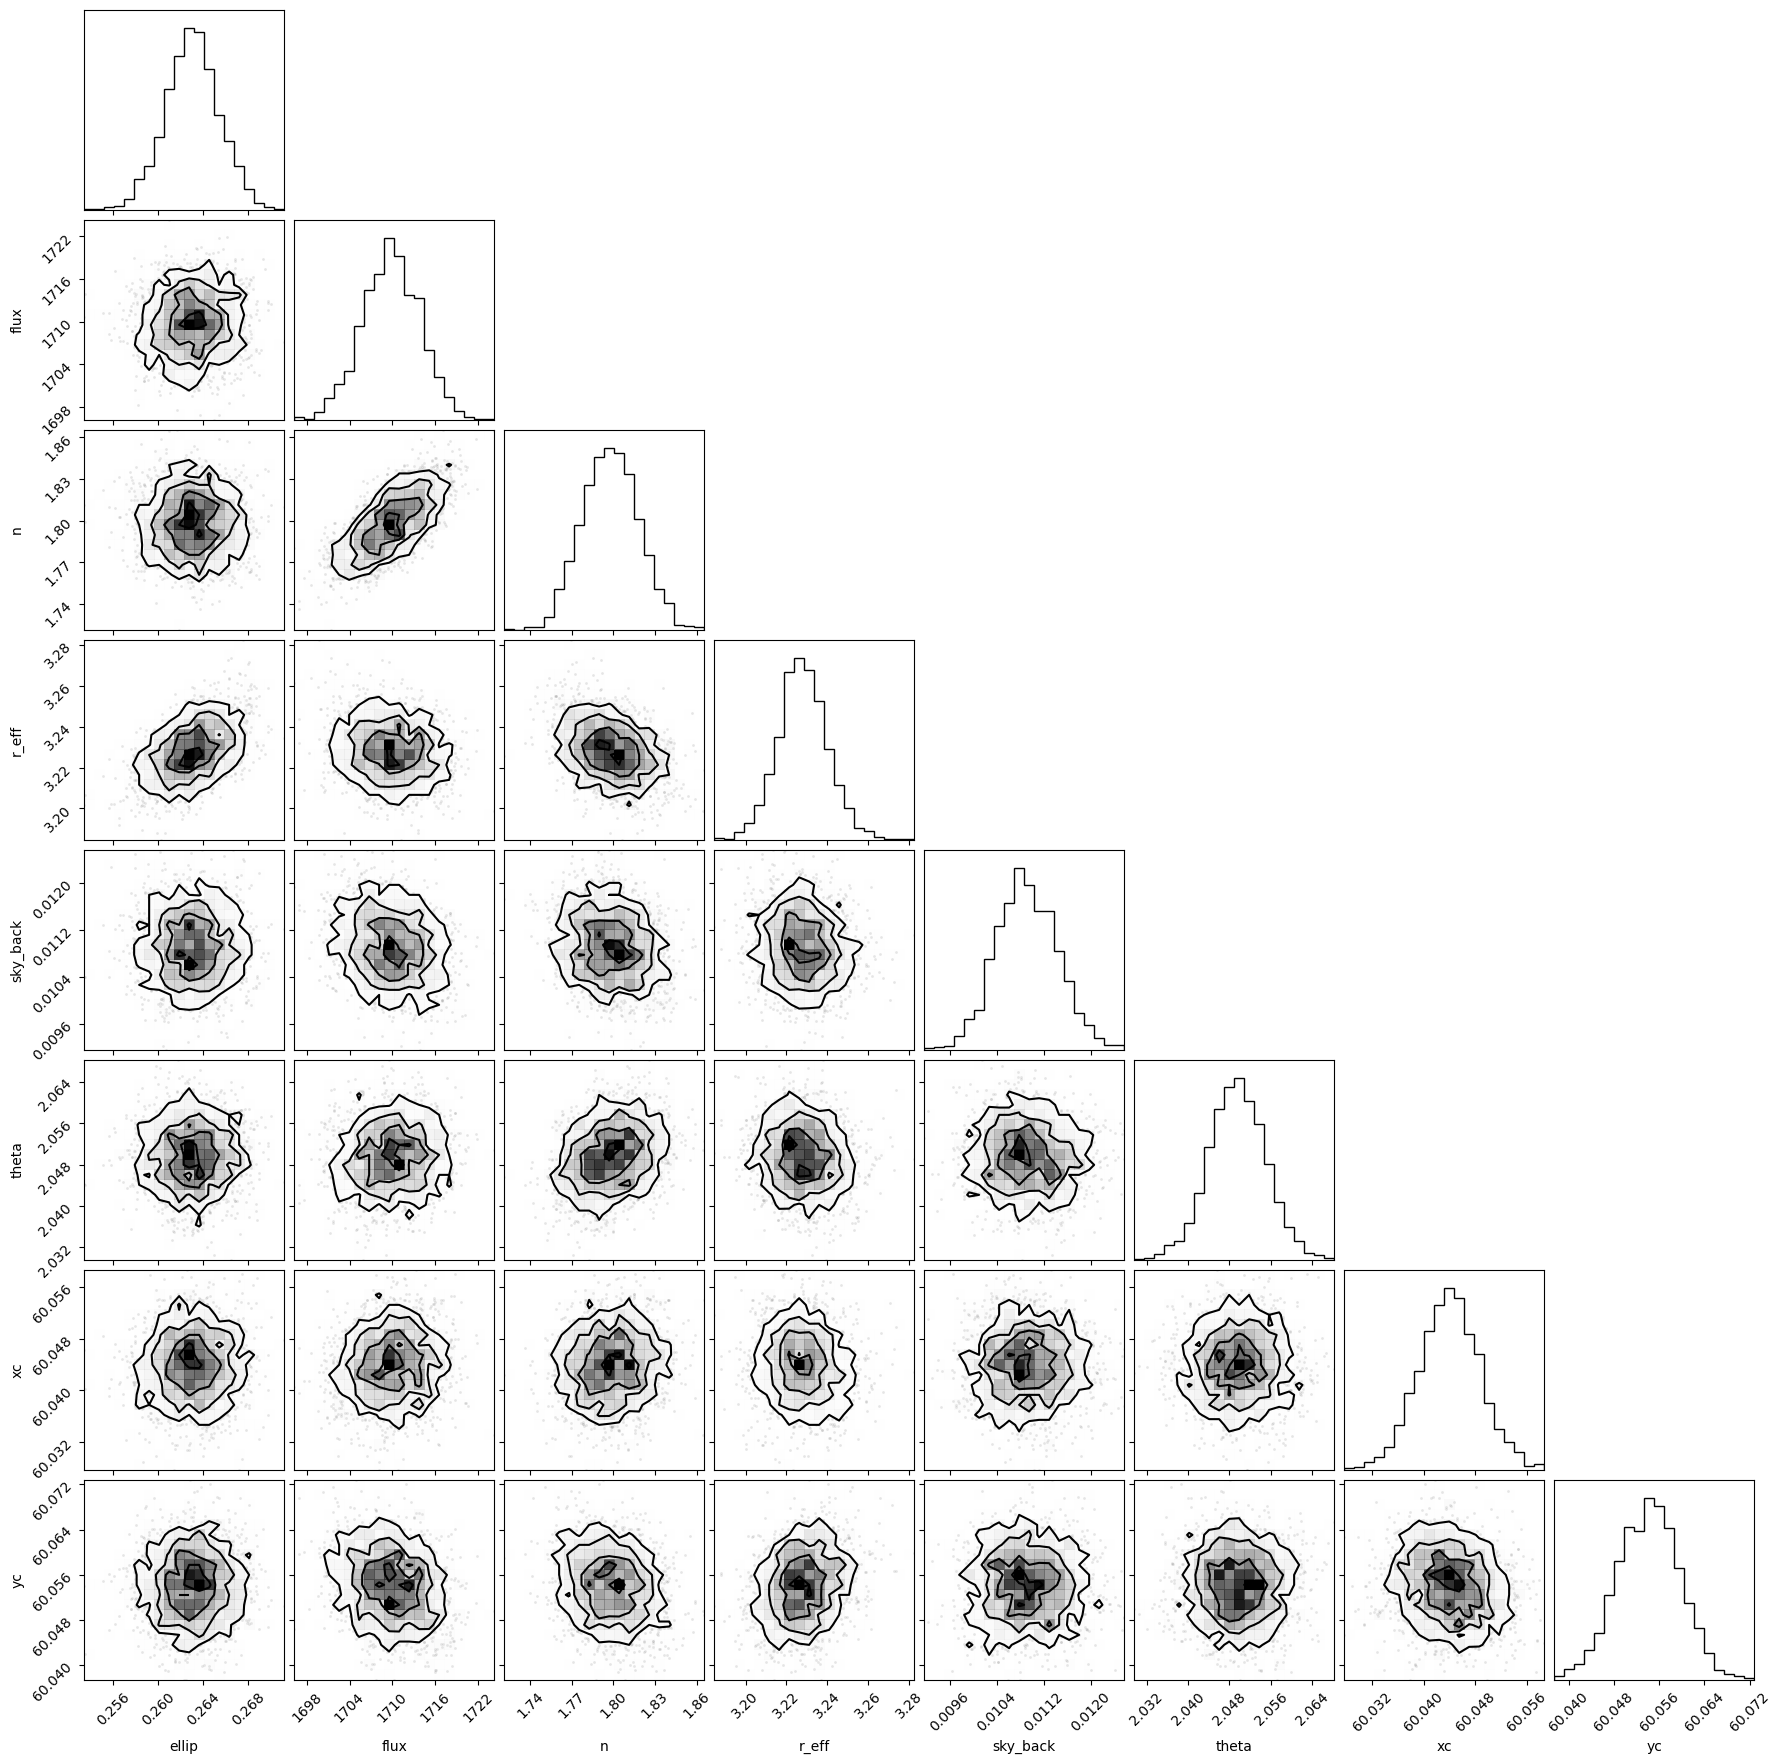

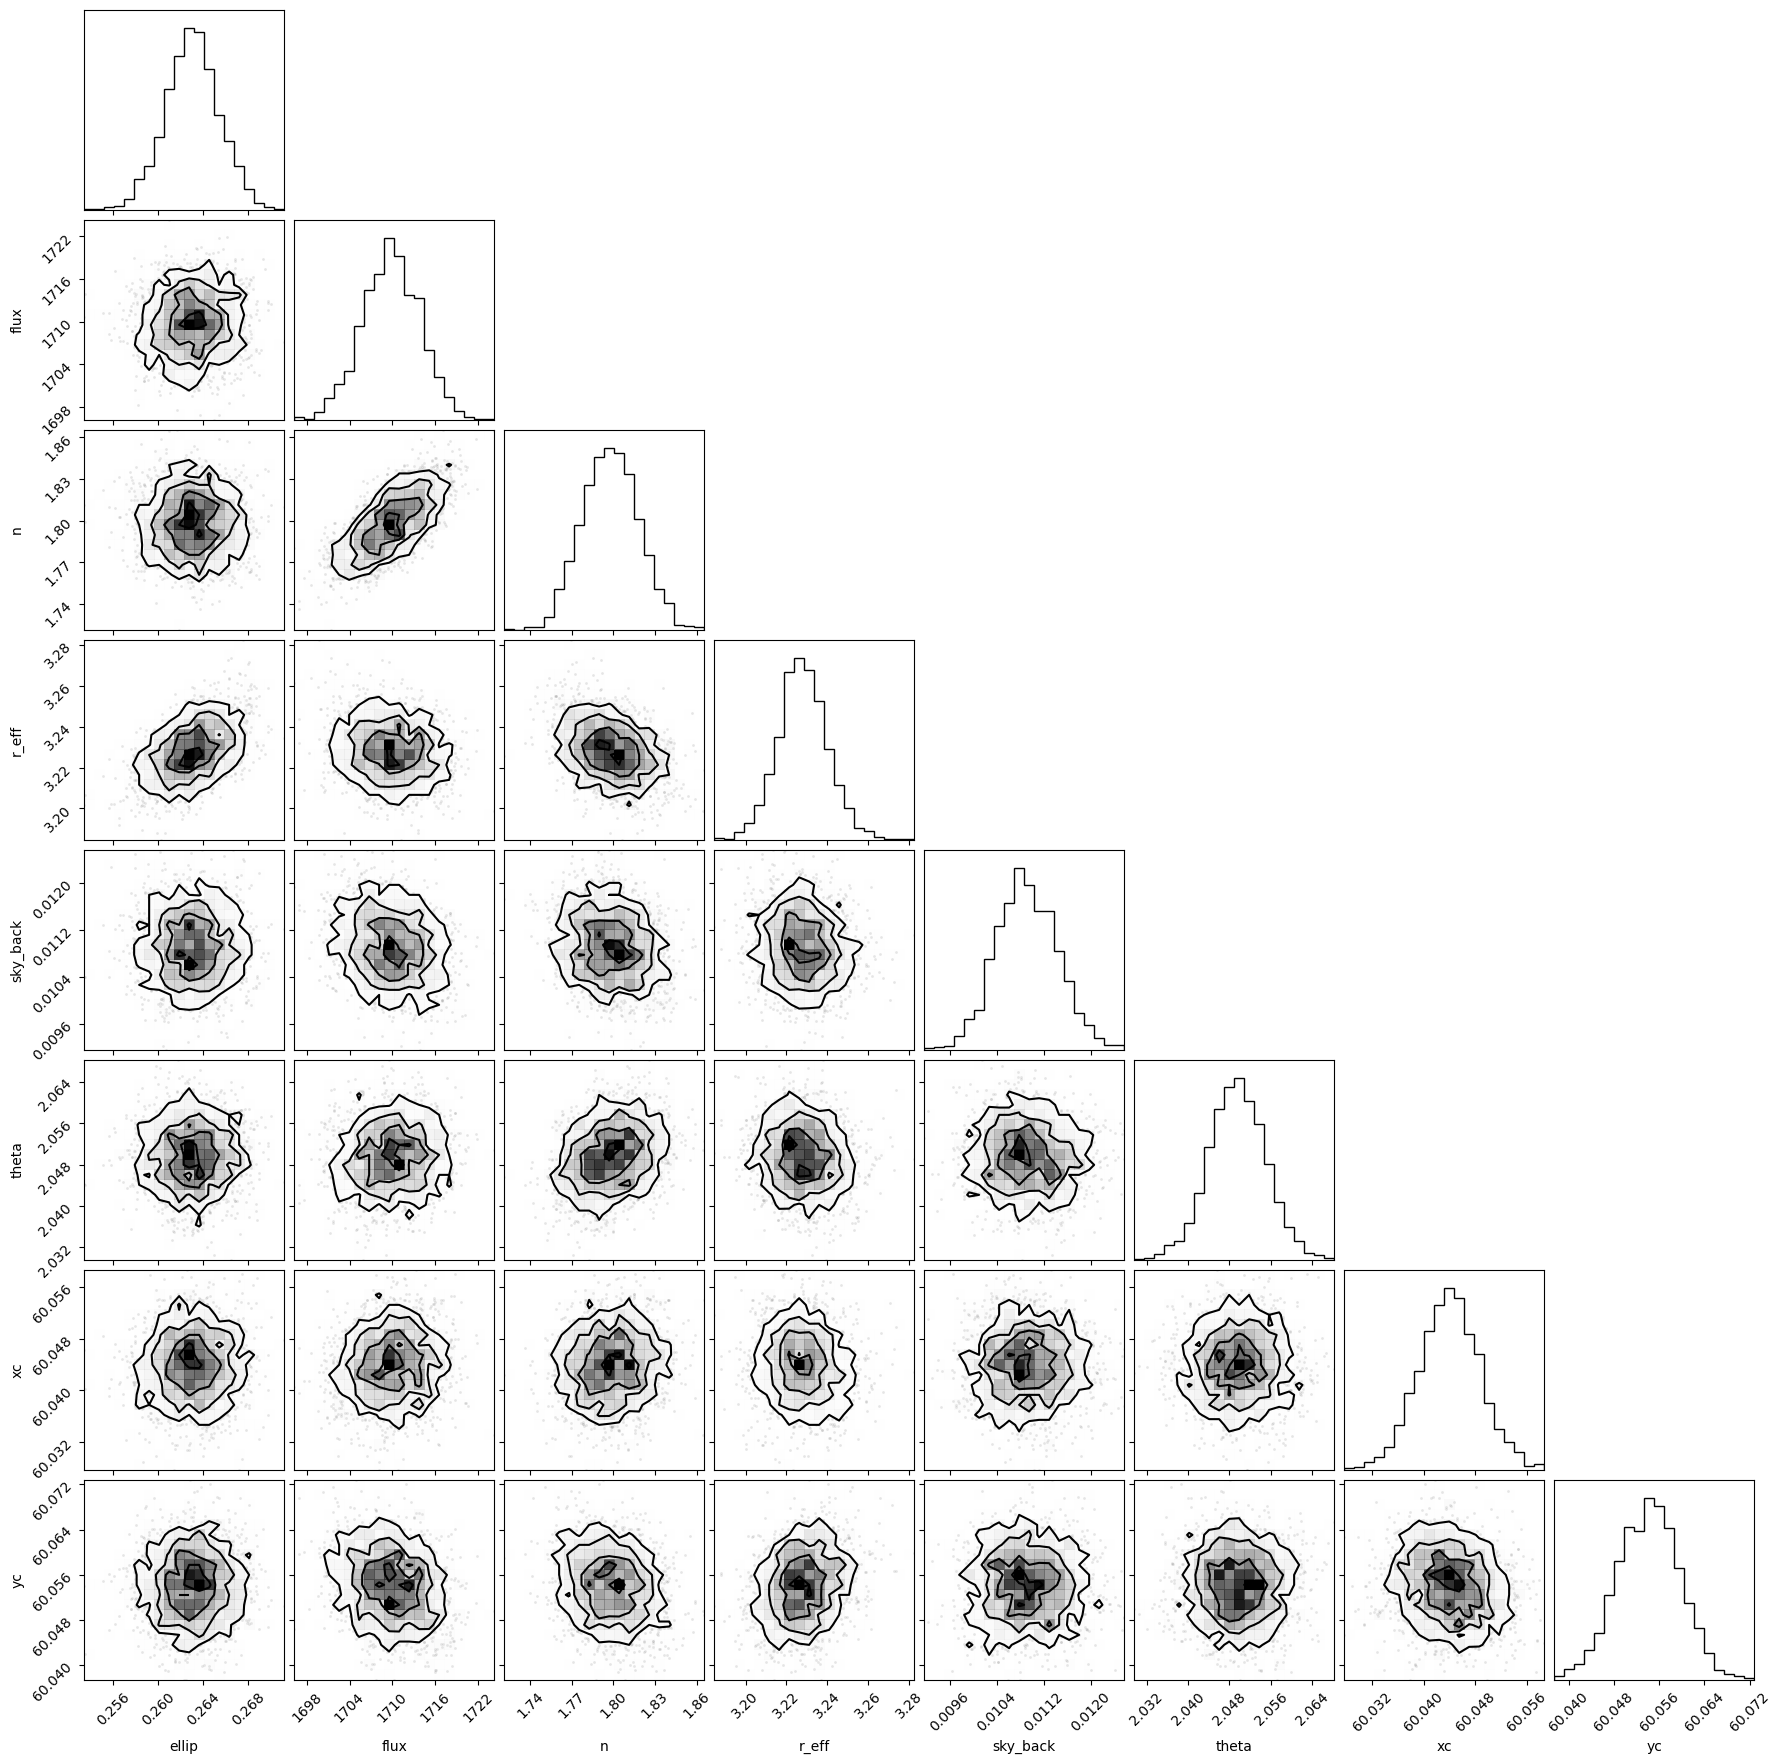

In [13]:
import corner 
corner.corner(af.tree['sampling_posterior'])